In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import astropy.units as u
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex
import warnings

from astropy.convolution import convolve, Gaussian2DKernel
from astropy.coordinates import Distance
from m33_utils import open_and_select, deg_to_deproj

from matplotlib import patches, path, patheffects
from scipy.ndimage import median_filter

sns.set(style='ticks', 
        rc={'font.family'          : 'serif', 
            'text.usetex'          : True, 
            'axes.axisbelow'       : True, 
            'mathtext.fontset'     : 'cm', 
            'mathtext.default'     : 'regular', 
            'xtick.direction'      : 'in', 
            'ytick.direction'      : 'in', 
            'xtick.major.width'    : 1.1, 
            'ytick.major.width'    : 1.1, 
            'axes.labelpad'        : 5.0, 
            'legend.framealpha'    : 0.95, 
            'legend.handlelength'  : 1.2, 
            'legend.handletextpad' : 0.5, 
       })

pal = sns.color_palette('colorblind')
dark = sns.color_palette('dark')
sns.set_palette(pal)

warnings.simplefilter('ignore')

def add_colorbar(fig, ax, cmap='viridis', vmin=0, vmax=1, 
                 norm='Normalize', n_colors=None, norm_args={}, 
                 offset=0.0175, width=0.0225, label='Number of stars'):
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+offset, pos.y0, width, pos.height])
    cmap_mpl = plt.get_cmap(cmap, n_colors)
    norm_mpl = getattr(mpl.colors, norm)(**norm_args, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_mpl, cmap=cmap_mpl), 
                        cax=cax, label=label)
    return cbar

In [2]:
ds = open_and_select('../legacy_phot/M33_full_matched.hdf5')

In [3]:
ra_m33, dec_m33 = 23.4625*u.deg, 30.6602*u.deg

dmod = 24.67
dm33 = Distance(distmod=dmod).to(u.kpc)

def deg2diff(ra, dec, ra0, dec0):
    dRA, dDec = (ra-ra0), (dec-dec0)
    return dRA*np.cos(dec0), dDec

def diff2deg(dra, ddec, ra0, dec0):
    ra, dec = ra0+dra/np.cos(dec0), ddec+dec0
    return ra, dec

# reddening-free F160W magnitude
ds['q'] = ds.F160W_VEGA - ((ds.F110W_VEGA-ds.F160W_VEGA)-1.) * 0.2029/(0.3266 - 0.2029)
ds['dist'] = np.sqrt( ((ds.RA-ra_m33.value)*np.cos(dec_m33.to('rad')))**2 + \
                      (ds.DEC-dec_m33.value)**2 )

distA, distB = deg_to_deproj(ds.RA, ds.DEC)
ds['dist2'] = (distA**2 + distB**2)**0.5

# Select old stars with both a shallow and deep selection (to scale RGB counts)
ds.select('IR_GST & ~F275W_GST & '
          '(dist > 0.02)', name='OLD_IR_outer')
ds.select('IR_GST & ~F275W_GST & '
          '(dist <= 0.02)', name='OLD_IR_inner')
ds.select('OLD_IR_inner | OLD_IR_outer', name='OLD_IR')

# RGB selection in F110W/F160W
prgb_ir = path.Path([(0.6, 22), (2, 22), 
                     (2, 18.7), (0.9, 18.7), 
                     (0.6, 22)])
ds.select_lasso('F110W_VEGA-F160W_VEGA', 'q', 
                *prgb_ir.vertices.T, name='RGB_yn')
ds.select('RGB_yn & OLD_IR_outer & (F110W_VEGA < 24.5)', name='RGB_outer')
ds.select('RGB_yn & OLD_IR_inner & (F110W_VEGA < 23.5) & (q < 21)', name='RGB_inner')
ds.select('RGB_outer | RGB_inner', name='RGB')
ds.select('RGB_yn & OLD_IR & (F110W_VEGA < 23.5) & (q < 21)', name='RGB_bright')

# AGB selection in F110W/F160W
pagb_ir = path.Path([(0.9, 18.5), (2, 18.5), 
                     (2, 16), (1.03, 16), 
                     (0.9, 18.5)])

ds.select_lasso('F110W_VEGA-F160W_VEGA', 'q', 
                *pagb_ir.vertices.T, name='AGB_yn')
ds.select('AGB_yn & IR_GST', name='AGB')

# Compute scale factor between inner and outer disk
ds.select('IR_GST & ~F275W_GST & '
          '(F110W_VEGA < 24.5) & (q < 22) & '
          '(dist > 0.0199) & (dist < 0.0201) & '
          'RGB_yn', name='OUTER_SCALE')
ds.select('IR_GST & ~F275W_GST & '
          '(F110W_VEGA < 23.5) & (q < 21) & '
          '(dist > 0.0199) & (dist < 0.0201) & '
          'RGB_yn', name='INNER_SCALE')
scale_factor = ds.count(selection='OUTER_SCALE')/ds.count(selection='INNER_SCALE')

# Young star selection in F475W/F814W
ds.select('UV_GST & OPT_GST & IR_GST', name='VERY_BRIGHT')

pms = path.Path([(-0.4, 24), (0.5, 24), 
                 (-0.1, 18), (-0.4, 18), 
                 (-0.4, 24)])
ds.select_lasso('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', 
                *pms.vertices.T, name='MS_yn')

ds.select('MS_yn & VERY_BRIGHT', name='MS')

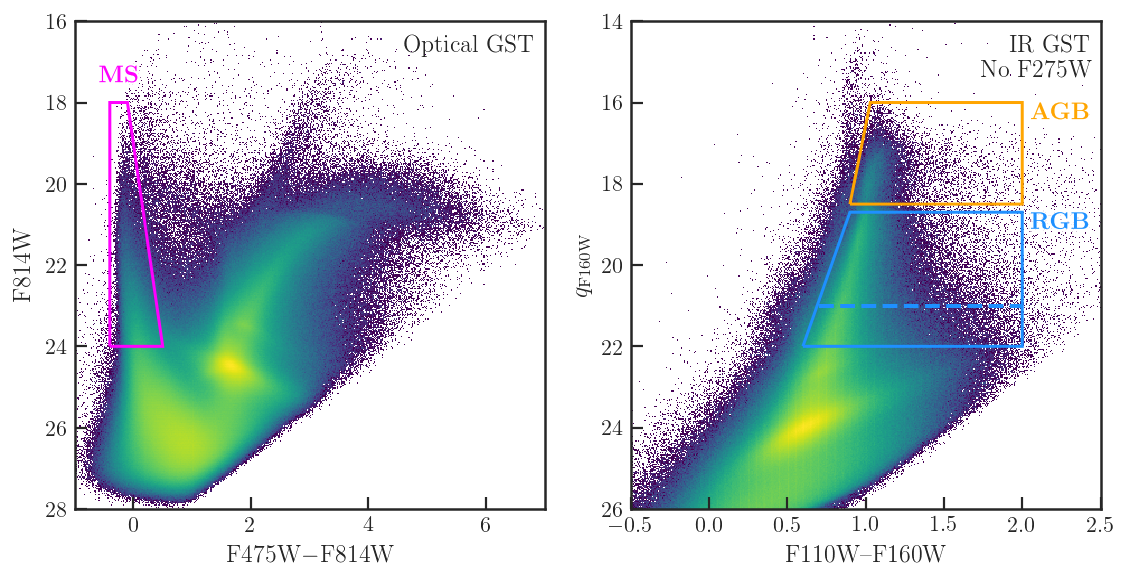

In [4]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 4.2))

plt.sca(ax)
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', selection='OPT_GST', shape=420, 
        f='log10', limits=[[-1, 7], [28, 16]], xlabel='F475W--F814W', ylabel='F814W', 
        interpolation='None', colormap='viridis', colorbar=False)
ax.set_xlabel(r'F475W$-$F814W')
ax.set_ylabel(r'F814W')

ax.add_patch(patches.PathPatch(pms, facecolor='none', edgecolor='magenta', lw=1.5))

stroke = patheffects.withStroke(linewidth=3, foreground='w', alpha=0.9)
ax.text(-0.25, 17.5, '$\mathbf{MS}$', color='magenta', ha='center', path_effects=[stroke])
ax.text(0.98, 0.97, 'Optical GST', va='top', ha='right', transform=ax.transAxes)

ax2 = plt.subplot(1, 2, 2)
ax2.set_xlabel(r'F110W$-$F160W')
ax2.set_ylabel(r'$q_{\rm F160W}$')

# IR CMD of old populations
ds.plot('F110W_VEGA-F160W_VEGA', 'q', selection='OLD_IR', shape=420, 
        f='log10', limits=[[-0.5, 2.5], [26, 14]], xlabel='F110W--F160W', ylabel='$q_{\mathrm{F160W}}$', 
        interpolation='None', colormap='viridis', colorbar=False)

ax2.add_patch(patches.PathPatch(prgb_ir, facecolor='none', edgecolor='dodgerblue', lw=1.5))
ax2.add_patch(patches.PathPatch(pagb_ir, facecolor='none', edgecolor='orange', lw=1.5))

ax2.text(2.05, 18.7, '$\mathbf{RGB}$', color='dodgerblue', va='top', path_effects=[stroke])
ax2.text(2.05, 16, '$\mathbf{AGB}$', color='orange', va='top', path_effects=[stroke])
ax2.hlines(21, 0.7, 2, linestyle='--', color='dodgerblue', lw=2)
ax2.text(0.98, 0.97, 'IR GST\nNo F275W', va='top', ha='right', transform=ax2.transAxes)

fig.savefig('figures/CMD_selections_RGB_AGB_MS_mjd.pdf', dpi=300, bbox_inches='tight')

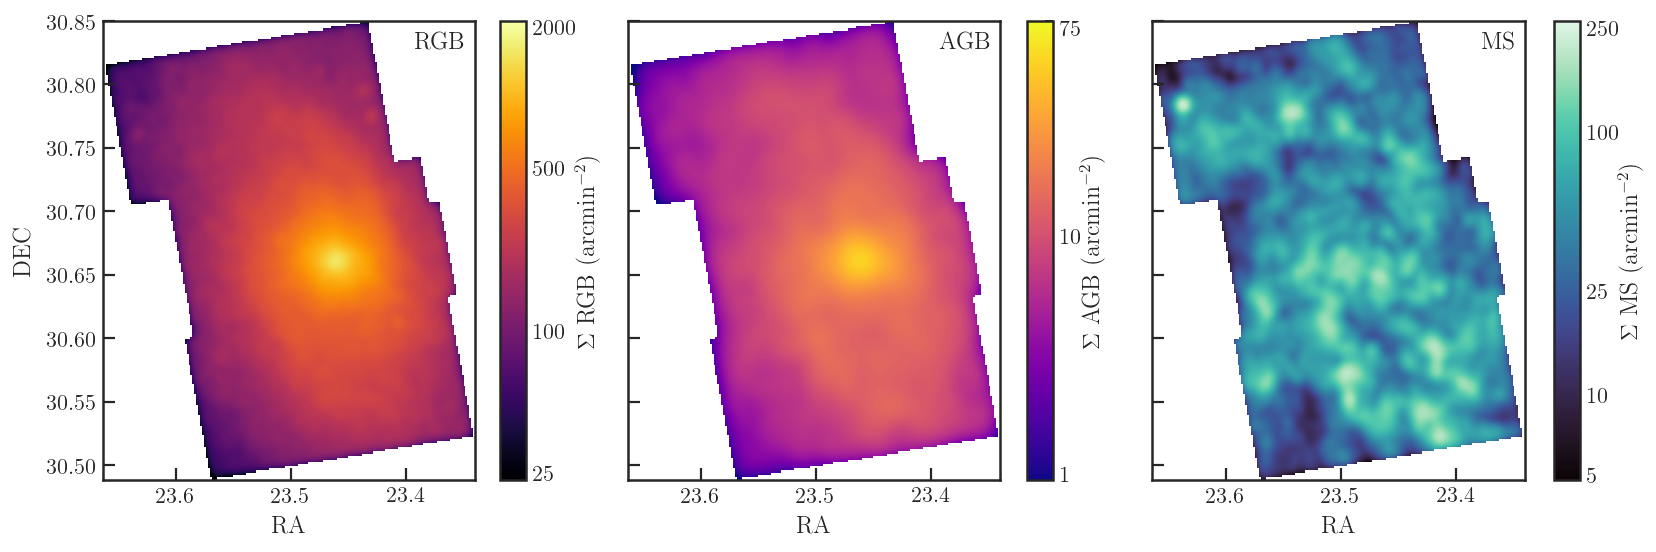

In [5]:
ra_round, dec_round = np.round(ds.minmax(['RA', 'DEC']) * 600)
ra_shape = np.diff(ra_round).astype(int)[0]
dec_shape = np.diff(dec_round).astype(int)[0]
ra_lim = ra_round / 600
dec_lim = dec_round / 600

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

plt.sca(ax1)
vmin_rgb, vmax_rgb, cmap_rgb = 2.33, 210, 'inferno'
allstars = ds.mean('RA', selection='F160W_VEGA < 99', binby=['DEC', 'RA'],
                    limits=[dec_lim, ra_lim], shape=(dec_shape, ra_shape))
rgb_outer = ds.count('*', selection='RGB_outer', binby=['DEC', 'RA'], 
                     limits=[dec_lim, ra_lim], shape=(dec_shape, ra_shape))
rgb_inner = ds.count('*', selection='RGB_inner', binby=['DEC', 'RA'], 
                     limits=[dec_lim, ra_lim], shape=(dec_shape, ra_shape)) * scale_factor
rgb = rgb_outer + rgb_inner
rgb_conv = convolve(rgb, Gaussian2DKernel(x_stddev=2.5))
rgb_conv[~np.isfinite(allstars)] = np.nan
ax1.imshow(rgb_conv, origin='lower', aspect=1.1, cmap=cmap_rgb, 
           norm=mpl.colors.LogNorm(vmin=vmin_rgb, vmax=vmax_rgb), 
           extent=[*ra_lim, *dec_lim], interpolation=None)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')

plt.sca(ax2)
vmin_agb, vmax_agb, cmap_agb = 0.095, 8, 'plasma'
agb = ds.count('*', selection='AGB', binby=['DEC', 'RA'], 
               limits=[dec_lim, ra_lim], shape=(dec_shape, ra_shape))
agb_conv = convolve(agb, Gaussian2DKernel(x_stddev=5))
agb_conv[~np.isfinite(allstars)] = np.nan
ax2.imshow(agb_conv, origin='lower', aspect=1.1, cmap=cmap_agb, 
           norm=mpl.colors.LogNorm(vmin=vmin_agb, vmax=vmax_agb), 
           extent=[*ra_lim, *dec_lim], interpolation=None)
# ds.plot('RA', 'DEC', selection='AGB', limits='minmax', shape=150, 
#         f='log10', aspect=1.1, colormap=cmap_agb, smooth_pre=1, smooth_post=0.6, interpolation='None', 
#         vmin=np.log10(vmin_agb), vmax=np.log10(vmax_agb), colorbar=False) 

plt.sca(ax3)
vmin_ms, vmax_ms, cmap_ms = 0.475, 26.5, sns.color_palette('mako', as_cmap=True)
ms = ds.count('*', selection='MS', binby=['DEC', 'RA'], 
              limits=[dec_lim, ra_lim], shape=(dec_shape, ra_shape))
ms_conv = convolve(ms, Gaussian2DKernel(x_stddev=2.5))
ms_conv[~np.isfinite(allstars)] = np.nan
ax3.imshow(ms_conv, origin='lower', aspect=1.1, cmap=cmap_ms, 
           norm=mpl.colors.LogNorm(vmin=vmin_ms, vmax=vmax_ms), 
           extent=[*ra_lim, *dec_lim], interpolation=None)
# ds.plot('RA', 'DEC', selection='MS', limits='minmax', shape=150, 
#         f='log10', aspect=1.1, colormap=cmap_ms, smooth_pre=0.6, smooth_post=0.4, interpolation='None', 
#         vmin=np.log10(vmin_ms), vmax=np.log10(vmax_ms), colorbar=False) 

for ax, label in zip([ax1, ax2, ax3], ['RGB', 'AGB', 'MS']):
    ax.invert_xaxis()
    ax.text(0.975, 0.975, label, va='top', ha='right', transform=ax.transAxes)
    if ax != ax1:
        ax.set_yticklabels([])
        ax.set_ylabel('')
        ax.set_xlabel('RA')

fig.tight_layout(w_pad=7)

cb = add_colorbar(fig, ax1, cmap=cmap_rgb, vmin=vmin_rgb*10, vmax=vmax_rgb*10, 
                  norm='LogNorm', offset=0.04, width=0.015)
ticks_rgb = [25, 100, 500, 2000]
cb.set_ticks(ticks_rgb)
cb.set_ticklabels(ticks_rgb)
cb.set_label('$\Sigma$ RGB (arcmin$^{-2}$)', labelpad=-1)
cb = add_colorbar(fig, ax2, cmap=cmap_agb, vmin=vmin_agb*10, vmax=vmax_agb*10, 
             norm='LogNorm', offset=0.01, width=0.015, label=None)
ticks_agb = [1, 10, 75]
cb.set_ticks(ticks_agb)
cb.set_ticklabels(ticks_agb)
cb.set_label('$\Sigma$ AGB (arcmin$^{-2}$)', labelpad=-1)
cb = add_colorbar(fig, ax3, cmap=cmap_ms, vmin=vmin_ms*10, vmax=vmax_ms*10, 
                  norm='LogNorm', offset=-0.02, width=0.015)
ticks_ms = [5, 10, 25, 100, 250]
cb.set_ticks(ticks_ms)
cb.set_ticklabels(ticks_ms)
cb.set_label('$\Sigma$ MS (arcmin$^{-2}$)', labelpad=-1)

fig.tight_layout()
fig.savefig('figures/AGB_RGB_MS_mjd.pdf', dpi=300, bbox_inches='tight')

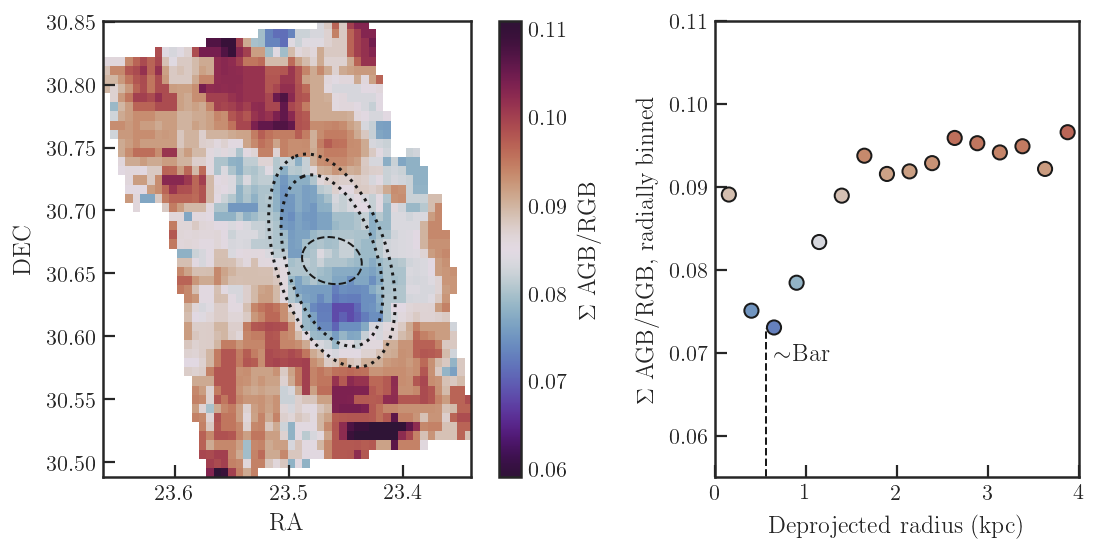

In [6]:
rgb_bright = ds.count('*', binby=['DEC', 'RA'], selection='RGB_bright', 
                      shape=50, limits=[ds.minmax('DEC'), ds.minmax('RA')])
agb = ds.count('*', binby=['DEC', 'RA'], selection='AGB', 
               shape=50, limits=[ds.minmax('DEC'), ds.minmax('RA')])

rad_lim, rad_shape = [0.03, 4], 16 # photometry at the v center is wonky
rad_kwargs = dict(limits=rad_lim, shape=rad_shape)
rgb_radial = ds.count('*', binby=['dist2'], selection='RGB_bright', **rad_kwargs)
agb_radial = ds.count('*', binby=['dist2'], selection='AGB', **rad_kwargs)
dist = ds.bin_centers('dist2',  **rad_kwargs)

ratio = agb/rgb_bright
ratio[(rgb_bright < 3)|(agb < 3)] = 0

# extend regions at survey edges
shifts = np.r_[range(1, 6)]
for shift in np.r_[shifts, -shifts[::-1]]:
    for axis in [0, 1]:        
        r_shifted = np.roll(ratio, shift=shift, axis=axis)
        idx = (rgb_bright < 1) & (r_shifted > 0)
        ratio[idx] = r_shifted[idx]

fratio = median_filter(ratio, 7, mode='mirror')
fratio[rgb_bright < 1] = np.nan

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios':[1.5, 1]})
vmin_ratio, vmax_ratio, cmap_ratio = 0.059, 0.111, 'twilight_shifted'
im = ax1.imshow(fratio, origin='lower', aspect=1.1, extent=[*ds.minmax('RA'), *ds.minmax('DEC')], 
                vmin=vmin_ratio, vmax=vmax_ratio, cmap=cmap_ratio)
fig.colorbar(im, ax=ax1, label='$\Sigma$ AGB/RGB')
ax1.invert_xaxis()
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')

inc, pa = np.deg2rad([49, 90-21.1]) #np.deg2rad([47.5, 73.98])
ba = np.arccos(inc)
phi = np.linspace(0, 2*np.pi, 1000)
for radius in [0.07141913, 0.08875006]:
    x = radius*np.cos(phi)
    y = radius*ba * np.sin(phi)
    xp = x*np.cos(pa) - y*np.sin(pa) + ra_m33.value
    yp = x*np.sin(pa) + y*np.cos(pa) + dec_m33.value
    ax1.plot(xp, yp, 'k:', lw=1.5)

xb = 0.0263*np.cos(phi)
yb = 0.0263*(1.-0.3) * np.sin(phi)
theta = np.deg2rad(10)
xbp = xb*np.cos(theta) + yb*np.sin(theta) + ra_m33.value
ybp = xb*np.sin(theta) - yb*np.cos(theta) + dec_m33.value
ax1.plot(xbp, ybp, 'k--', lw=1)

ax2.scatter(dist, agb_radial/rgb_radial, c=agb_radial/rgb_radial, 
            cmap='twilight_shifted', vmin=vmin_ratio, vmax=vmax_ratio, edgecolor='k', s=50)
ax2.set_ylim(0.055, 0.11)
ax2.set_ylabel('$\Sigma$ AGB/RGB, radially binned')

bar_max = np.max(deg_to_deproj(xbp, ybp))
ax2.vlines(bar_max, 0.05, 0.073, color='k', linestyle='--', lw=1, zorder=-1)
ax2.text(0.65, 0.069, r'$\sim$Bar', ha='left')
ax2.set_xlabel('Deprojected radius (kpc)')
ax2.set_xlim(0, 4)

fig.tight_layout()
fig.savefig('figures/AGB_RGB_ratio_mjd.pdf', dpi=300, bbox_inches='tight')